In [26]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-apr-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-apr-2022/train_labels.csv
/kaggle/input/tabular-playground-series-apr-2022/train.csv
/kaggle/input/tabular-playground-series-apr-2022/test.csv


In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import random

In [28]:
train = pd.read_csv('/kaggle/input/tabular-playground-series-apr-2022/train.csv')
test = pd.read_csv('/kaggle/input/tabular-playground-series-apr-2022/test.csv')
train_labels = pd.read_csv('/kaggle/input/tabular-playground-series-apr-2022/train_labels.csv')

In [29]:
train = train.join(train_labels, on='sequence', rsuffix='_replica').drop(columns = 'sequence_replica')

# EDA

## Basic information

In [30]:
print(train.shape)
print(test.shape)
print(train.isnull().sum())
print(test.isnull().sum())
print(train.head())
print(train.tail())
print(train.describe())


(1558080, 17)
(733080, 16)
sequence     0
subject      0
step         0
sensor_00    0
sensor_01    0
sensor_02    0
sensor_03    0
sensor_04    0
sensor_05    0
sensor_06    0
sensor_07    0
sensor_08    0
sensor_09    0
sensor_10    0
sensor_11    0
sensor_12    0
state        0
dtype: int64
sequence     0
subject      0
step         0
sensor_00    0
sensor_01    0
sensor_02    0
sensor_03    0
sensor_04    0
sensor_05    0
sensor_06    0
sensor_07    0
sensor_08    0
sensor_09    0
sensor_10    0
sensor_11    0
sensor_12    0
dtype: int64
   sequence  subject  step  sensor_00  sensor_01  sensor_02  sensor_03  \
0         0       47     0  -0.196291   0.112395        1.0   0.329204   
1         0       47     1  -0.447450   0.134454        1.0  -0.658407   
2         0       47     2   0.326893  -0.694328        1.0   0.330088   
3         0       47     3   0.523184   0.751050        1.0   0.976991   
4         0       47     4   0.272025   1.074580        1.0  -0.136283   

   sens

In [31]:
print(len(train.subject.unique()))
print(len(train.sequence.unique()))

672
25968


## Sequence Number for Each Subject 
We explore how many sequences for each subject and the distribution of sequence numbers over all subject in the train data.

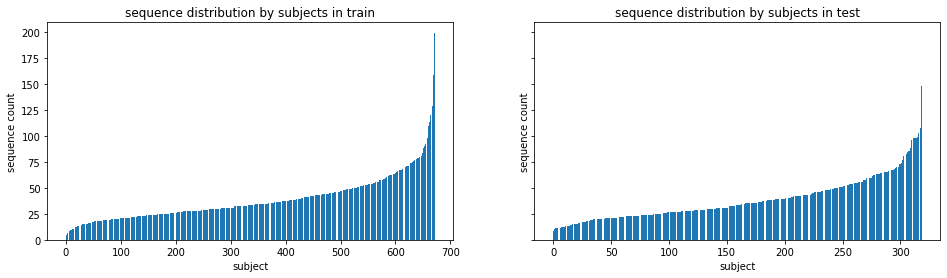

In [32]:
plt.subplots(1, 2, sharey=True, figsize=(16, 4))
def plot_sequence_dist_subject(df, title):
    temp = df.subject.value_counts().sort_values() // 60  # 
    plt.bar(range(len(temp)), temp)
    plt.xlabel('subject')
    plt.ylabel('sequence count')
    plt.title(f'sequence distribution by subjects in {title}')


plt.subplot(1, 2, 1)
plot_sequence_dist_subject(train, 'train')
plt.subplot(1, 2, 2)
plot_sequence_dist_subject(test, 'test')


In [33]:
train.head()

,sequence,subject,step,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12,state
0,0,47,0,-0.196291,0.112395,1.0,0.329204,-1.004660,-0.131638,-0.127505,0.368702,-0.1,-0.963873,-0.985069,0.531893,4.751492,0
1,0,47,1,-0.447450,0.134454,1.0,-0.658407,0.162495,0.340314,-0.209472,-0.867176,0.2,-0.301301,0.082733,-0.231481,0.454390,0
2,0,47,2,0.326893,-0.694328,1.0,0.330088,0.473678,1.280479,-0.094718,0.535878,1.4,1.002168,0.449221,-0.586420,-4.736147,0
3,0,47,3,0.523184,0.751050,1.0,0.976991,-0.563287,-0.720269,0.793260,0.951145,-0.3,-0.995665,-0.434290,1.344650,0.429241,0
4,0,47,4,0.272025,1.074580,1.0,-0.136283,0.398579,0.044877,0.560109,-0.541985,-0.9,1.055636,0.812631,0.123457,-0.223359,0


In [34]:
subject_state = train[['subject', 'state']].groupby('subject').agg(['sum', 'count']).reset_index()

In [35]:
subject_state.columns = ['subject','state1_sum','state_count']
subject_state['state1_perc'] = subject_state.state1_sum/subject_state.state_count
subject_state.sort_values(by=['state1_perc'], inplace=True)

In [36]:
subject_state['state1_sum'] = subject_state['state1_sum'] / 60
subject_state['state_count'] = subject_state['state_count'] /60

In [37]:
subject_state.describe()

,subject,state1_sum,state_count,state1_perc
count,672.000000,672.000000,672.000000,672.000000
mean,335.500000,19.366071,38.642857,0.402607
std,194.133974,22.055882,22.087763,0.254644
min,0.000000,0.000000,2.000000,0.000000
25%,167.750000,5.000000,25.000000,0.200000
50%,335.500000,13.000000,33.000000,0.406250
75%,503.250000,26.250000,47.000000,0.605662
max,671.000000,177.000000,199.000000,0.984127


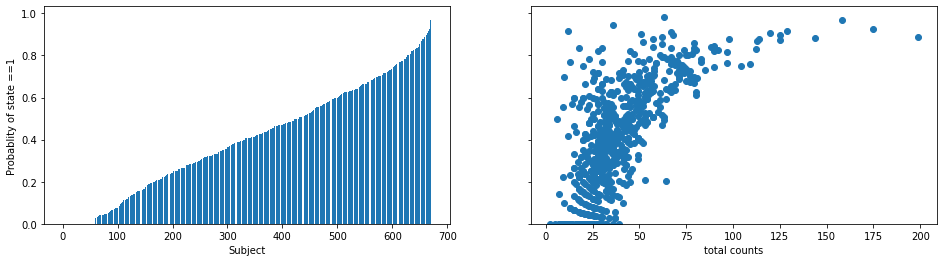

In [38]:
fig, axes= plt.subplots(1, 2, figsize=(16, 4), sharey=True)
axes[0].bar(range(len(subject_state)), subject_state.state1_perc)
axes[0].set_xlabel('Subject')
axes[0].set_ylabel('Probablity of state ==1')
axes[1].scatter(subject_state.state_count, subject_state.state1_perc)
axes[1].set_xlabel('total counts')
plt.show()

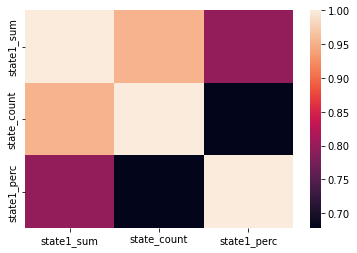

In [39]:
# correlation heatmap of total counts, counts of state1 and percentage of state1
subject_state.corr()
sns.heatmap(subject_state.corr().iloc[1:4, 1:4])
plt.show()

In [40]:
from sklearn.preprocessing import PolynomialFeatures

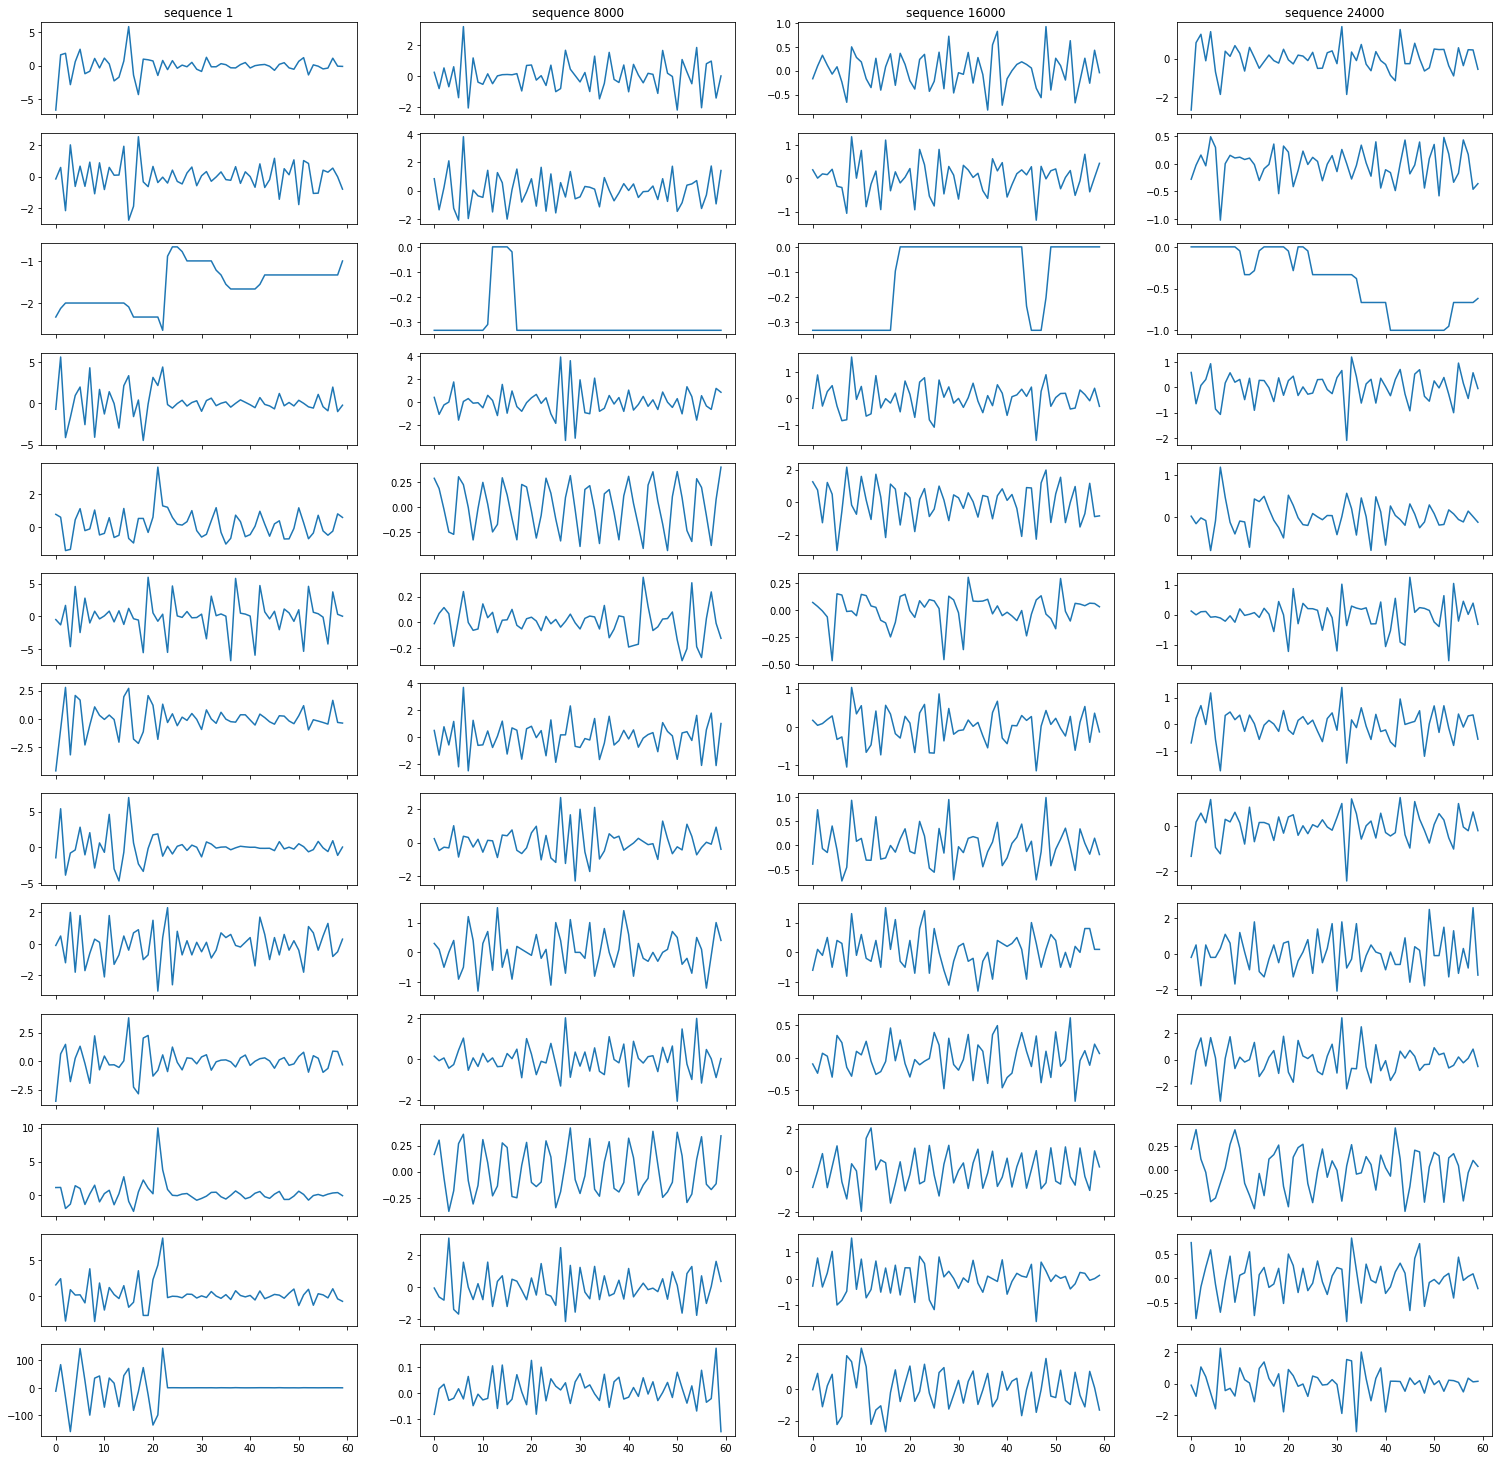

In [41]:
fig, axes = plt.subplots(13, 4, figsize=(26,26), sharex=True)
for seq, x in zip([1, 8000, 16000, 24000], range(4)):    
    temp = train[train.sequence == seq]
    for i in range(13):
        axes[i, x].plot(temp['step'], temp[f'sensor_{i:02d}'])
        if i == 0:
            axes[i,x].set_title(f'sequence {seq}')
plt.show()


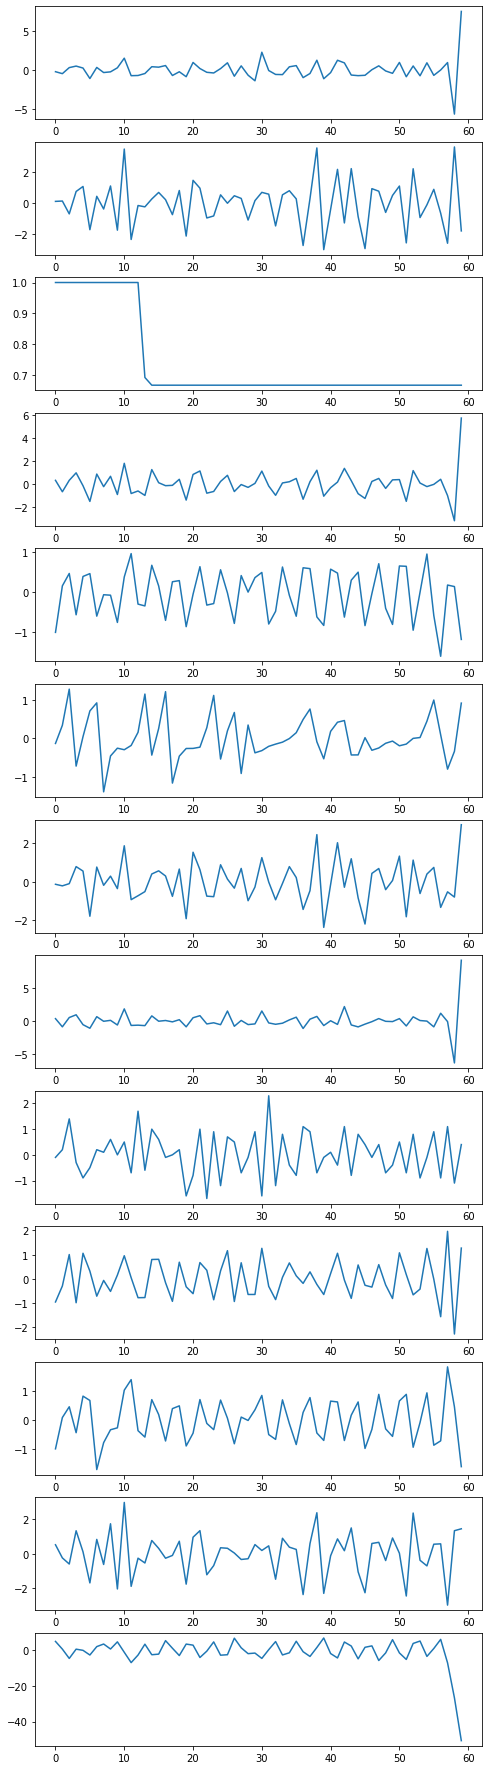

In [42]:
sequence_0 = train[train.sequence == 0]
fig, axes =  plt.subplots(13, 1, figsize=(8,32))
for i, ax in enumerate(axes.ravel()):
    ax.plot(sequence_0['step'], sequence_0[f'sensor_{i:02d}'])

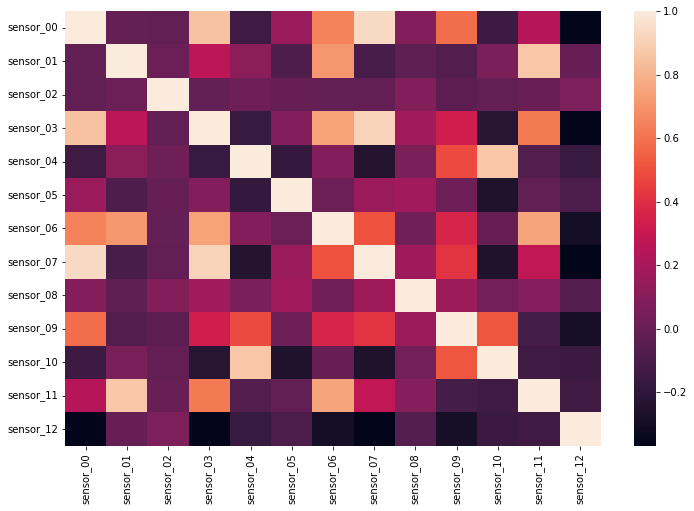

In [52]:
fig = plt.figure(figsize=(12,8))
sns.heatmap(sequence_0.corr().iloc[3:-1, 3:-1])
plt.show()

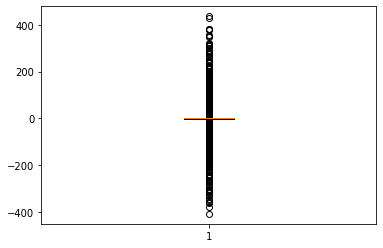

In [66]:

plt.boxplot(train['sensor_03'])
plt.show()

In [65]:
sensor_label = [s]

,sequence,subject,step,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12,state
0,0,47,0,-0.196291,0.112395,1.0,0.329204,-1.004660,-0.131638,-0.127505,0.368702,-0.1,-0.963873,-0.985069,0.531893,4.751492,0
1,0,47,1,-0.447450,0.134454,1.0,-0.658407,0.162495,0.340314,-0.209472,-0.867176,0.2,-0.301301,0.082733,-0.231481,0.454390,0
2,0,47,2,0.326893,-0.694328,1.0,0.330088,0.473678,1.280479,-0.094718,0.535878,1.4,1.002168,0.449221,-0.586420,-4.736147,0
3,0,47,3,0.523184,0.751050,1.0,0.976991,-0.563287,-0.720269,0.793260,0.951145,-0.3,-0.995665,-0.434290,1.344650,0.429241,0
4,0,47,4,0.272025,1.074580,1.0,-0.136283,0.398579,0.044877,0.560109,-0.541985,-0.9,1.055636,0.812631,0.123457,-0.223359,0


AxesSubplot(0.125,0.71587;0.168478x0.16413)
AxesSubplot(0.327174,0.71587;0.168478x0.16413)
AxesSubplot(0.529348,0.71587;0.168478x0.16413)
AxesSubplot(0.731522,0.71587;0.168478x0.16413)
AxesSubplot(0.125,0.518913;0.168478x0.16413)
AxesSubplot(0.327174,0.518913;0.168478x0.16413)
AxesSubplot(0.529348,0.518913;0.168478x0.16413)
AxesSubplot(0.731522,0.518913;0.168478x0.16413)
AxesSubplot(0.125,0.321957;0.168478x0.16413)
AxesSubplot(0.327174,0.321957;0.168478x0.16413)
AxesSubplot(0.529348,0.321957;0.168478x0.16413)
AxesSubplot(0.731522,0.321957;0.168478x0.16413)
AxesSubplot(0.125,0.125;0.168478x0.16413)


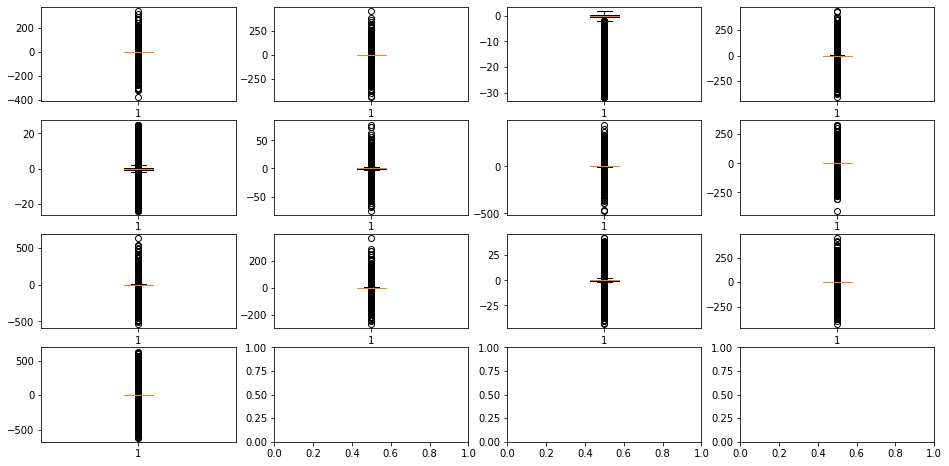

In [86]:
fig, axes = plt.subplots(4,4,figsize=(16,8))
for ax, i in zip(axes.ravel(), range(13)):
    ax.boxplot(train[f'sensor_{i:02d}'])
plt.show()
figure.tight_layout(h_pad=1.0, w_pad=0.5)